In [2]:
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [8]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from random import sample


%run ../src/mGST/reporting.py

In [9]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

In [10]:
X_true, E_true, rho_true = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')

In [11]:
def random_len_seq_3(d,min_l,max_l,N): #Draws without replacement but ineficiently (not working for sequence length > 24)
    seq_counts = []
    J = [-np.ones(max_l)]
    N_remaining = N - 1
    for l in range(min_l,max_l+1):
        seq_counts.append(int(np.min([np.floor(N_remaining/(max_l+1-l)), d**l])))
        ind_curr = np.array(sample(range(d**l), seq_counts[-1]))
        J_curr = np.array([np.pad(low_level_jit.local_basis(ind,d,l),(0,max_l-l),'constant', constant_values = -1) for ind in ind_curr])
        J = np.concatenate((J,J_curr), axis = 0)
        N_remaining = N - 1 - np.sum(seq_counts)
    if N_remaining > 0:
        print('Number of possible sequences without replacement for the given sequence\
        length range is lower than the desired total number of sequences')
    return J.astype(int)

In [12]:
l_min = 1
l_cut = 8
l_max = 24
N = 100
N_long = 50
meas_samples = 1e4
J = random_len_seq_3(d,l_min,l_cut,N)
J2 = random_len_seq_3(d,l_cut,l_max,N_long)

y = np.real(np.array([[E_true[i].conj()@low_level_jit.contract(X_true,j)@rho_true for j in J] for i in range(n_povm)]))
y = additional_fns.sampled_measurements(y,meas_samples).copy()

y2 = np.real(np.array([[E_true[i].conj()@low_level_jit.contract(X_true,j)@rho_true for j in J2] for i in range(n_povm)]))
y2 = additional_fns.sampled_measurements(y2,meas_samples).copy()

In [28]:
max_l_drawn = np.max(np.sum(J2>=0,axis = 1))
print(max_l_drawn)
J_all = []
for i in range(N):
    J_all.append(list(np.pad(J[i],(0,max_l_drawn-len(J[i])),'constant',constant_values=-1)))
for i in range(1,N_long):
    J_all.append(list(np.pad(J2[i],(0,max_l_drawn-len(J2[i])),'constant',constant_values=-1)))
J_all = np.array(J_all)
y_all = np.concatenate((y,y2), axis = 1)


J_reduced = [] #format for saving as cvs without "-1" placeholders
for i in range(N):
    J_reduced.append(list(J[i,:][J[i,:]>=0]))
for i in range(1,N_long):
    J_reduced.append(list(J2[i,:][J2[i,:]>=0]))


24


In [29]:
import csv

with open('sequences_1q.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows(J_reduced)

Starting optimization...
 16%|█▌        | 16/100 [01:00<05:15,  3.76s/it] 


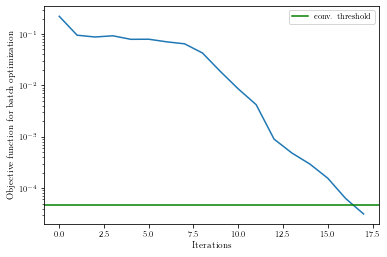

Initialization successful, improving estimate over full data....
 20%|██        | 8/40 [01:00<04:00,  7.51s/it]


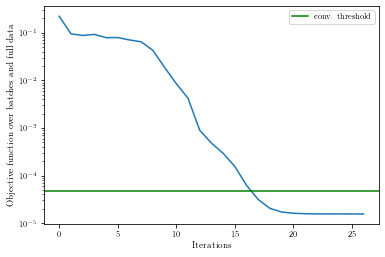

#################
	 Convergence criterion satisfied
	 Final objective function value 1.560564557991789e-05 with # of initializations: 1 
 	 Total runtime: 133.71666860580444
Starting optimization...
 52%|█████▏    | 52/100 [00:55<00:51,  1.07s/it]


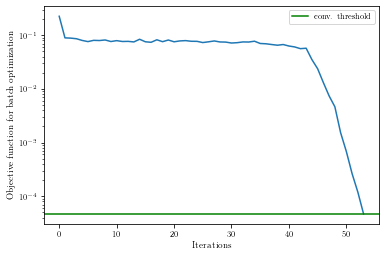

Initialization successful, improving estimate over full data....
 22%|██▎       | 9/40 [00:18<01:05,  2.10s/it]


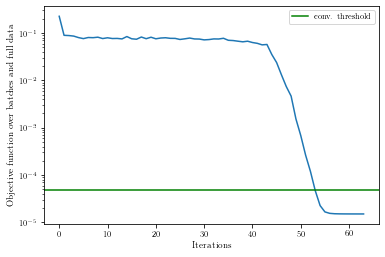

#################
	 Convergence criterion satisfied
	 Final objective function value 1.5077235988108356e-05 with # of initializations: 1 
 	 Total runtime: 76.73244976997375


In [14]:
bsize = 50   # The batch size on which the optimization is started

results = []
for rK in [1,4]: 
    K,X,E,rho,res_list = algorithm.run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 20, max_iter = 100, final_iter = 40, threshold_multiplier = 3, 
                         target_rel_prec = 1e-4,  testing = True)   
    results.append([K,X,E,rho])

In [18]:
K,X,E,rho = results[1][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99976","0,00152","0,00121"
Rx(pi/2)[q0],"0,99999","0,00087","0,00078"
Ry(pi/2)[q0],"0,33336","1,00000","0,00102"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000015,0.002732,0.002607,0.001089,0.001171


(None, None)

Starting optimization...
 10%|█         | 4/40 [00:03<00:34,  1.03it/s]


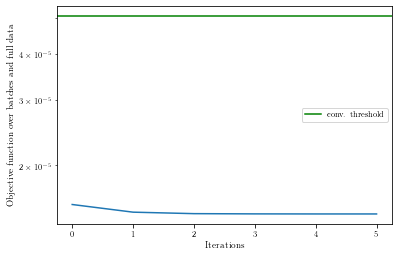

#################
	 Convergence criterion satisfied
	 Final objective function value 1.4734947042919395e-05 with # of initializations: 1 
 	 Total runtime: 4.399519920349121
Starting optimization...
 10%|█         | 4/40 [00:25<03:45,  6.26s/it]


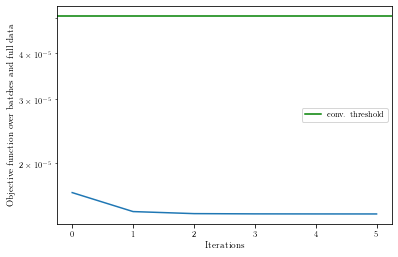

#################
	 Convergence criterion satisfied
	 Final objective function value 1.4549218335506332e-05 with # of initializations: 1 
 	 Total runtime: 25.365276098251343


In [23]:
results_all = []
i = 0
for rK in [1,4]: 
    K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 20, max_iter = 0, final_iter = 40, threshold_multiplier = 3, 
                         target_rel_prec = 1e-4, init = [results[i][0], results[i][2], results[i][3]], testing = True)   
    results_all.append([K,X,E,rho])
    i+=1

In [24]:
K,X,E,rho = results_all[1][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99992","0,00067","0,00060"
Rx(pi/2)[q0],"1,00000","0,00061","0,00058"
Ry(pi/2)[q0],"0,33334","1,00000","0,00021"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000016,0.002647,0.002607,0.000484,0.001074


(None, None)